In [2]:
import numpy as np
import matplotlib.pyplot as plt
import functools as ft
from scipy.linalg import expm
from scipy.stats import unitary_group
from itertools import permutations

# Projected mixed state ensembles: Model II

Here I explore the mixed ensembles obtained through faulty measurement, with independent bitflip error $q$ for each bit. From a generic state on $AB$, a pure projected ensemble $\{p_m, \ket{\psi_m} \}$ is obtained labelled by true measurement outcomes $m$. Then the recorded measurement outcomes are different bitstrings $m'$, with error probability given by
$\begin{equation}
p(m'|m) = q^{\text{Ham}(m',m)} \cdot (1-q)^{N_B - \text{Ham}(m',m)}.
\end{equation}$
Then the ensemble of mixed states labelled by the faulty readouts $m'$ is given by $\{p_{m'}, \rho_{m'} \}$, with
$\begin{align}
p_{m'} &= \sum_m p(m'|m) p_m \\
\rho_{m'} &= \sum_m p(m'|m) \ket{\psi_m} \bra{\psi_m}
\end{align}$

In this code I obtain such mixed ensembles and explore them in various ways, with varying success.

### Functions
Here we have the Quantum Ising Mixed Field Hamiltonian following Cotler et al., a function to extract a projected ensemble on $A$ from a generic state on $AB$, and a function to obtain the ensemble of mixed states ('mixed ensemble') in the case of faulty measurement, with independent bitflip error $q$ everywhere.

In [11]:
# Parameters
sx = np.array([[0,1],[1,0]]) ;  sy = np.array([[0,-1j],[1j,0]])

def QIMF(N, h_x, h_y, J):

    # Single site term
    H1 = h_x * sx + h_y * sy
    # Interaction term
    H2 = J * np.kron(sx,sx)

    # Hamiltonian as a matrix
    H = np.zeros((2**N,2**N),dtype='complex128')
    for i in range(N):
        H += ft.reduce(np.kron, [np.identity(2**i), H1, np.identity(2**(N-i-1))])
    for i in range(N-2):
        H += ft.reduce(np.kron, [np.identity(2**i), H2, np.identity(2**(N-i-2))])
    
    return H

def random_state(d):
    '''Produces a Haar random state in d-dimensional Hilbert space as a numpy array.'''
    U = unitary_group.rvs(d)
    psi0 = np.zeros(d, dtype='complex128')
    psi0[0] = 1
    
    return U @ psi0

def Hamming(str_a, str_b):
    '''Returns the Hamming distance of two equal length strings'''
    Hamming = 0
    for i in range(len(str_a)):
        if str_a[i] != str_b[i]:
            Hamming += 1
    return Hamming

def bitstring(i, N_B):
    '''Returns the bitstring of N_B bits that corresponds to the base-10 integer i, for i between 0 and 2**N_B.'''
    return format(i, f'0{N_B}b')

def error_prob(m, m_prime, N_B, q):
    '''
    For single independent bitflip errors with probability p, returns the probability of reading m_prime for a true outcome m,
    for m and m_prime input as base-10 integers between 0 and 2**N_B.
    '''
    str_m = format(m, f'0{N_B}b')
    str_m_prime = format(m_prime, f'0{N_B}b')
    num_errors = Hamming(str_m, str_m_prime)
    prob = (q ** num_errors) * ((1-q) ** (N_B - num_errors))

    return prob

# From previous work: get projected ensemble on A from a state in AB
def Get_PrEns(Psi, N_A, N_B):
    PrEns = np.empty((2**N_B, 2)).tolist()

    for i in range(2**N_B):
        PsiA = Psi.reshape(2**N_A, 2**N_B)[:,i]
        PrEns[i][0] = np.linalg.norm(PsiA) ** 2
        PrEns[i][1] = PsiA / np.linalg.norm(PsiA)
    
    return PrEns

def Get_MixEns(PrEns, N_A, N_B, q):
    '''From a pure ensemble, return a mixed ensemble given an independent bitflip error p'''
    MixEns = np.empty((2 ** N_B, 2)).tolist()

    for m_prime in range(2 ** N_B):
        rho = np.zeros((2 ** N_A, 2 ** N_A), dtype='complex128')
        p_m_prime = 0

        for m in range(2 ** N_B):
            cond_prob = error_prob(m, m_prime, N_B, q)
            p_m_prime += cond_prob * PrEns[m][0]
            rho += cond_prob * np.outer(np.conjugate(PrEns[m][1]), PrEns[m][1])

        MixEns[m_prime][0] = p_m_prime
        MixEns[m_prime][1] = rho

    return MixEns

def rho_MixEns(MixEns, k):
    '''Get the k th moment of a mixed ensemble. Works for k = 1, 2, 3.'''
    d = np.shape(MixEns[0][1])[0]
    rho_k = np.zeros((d**k, d**k), dtype='complex128')

    for i in range(len(MixEns)):
        p_i = MixEns[i][0]
        state_i = MixEns[i][1]
        state_k_times = state_i
        for j in range(k-1):
            state_k_times = np.tensordot(state_k_times, state_i, axes=0)
    
        rho_k += p_i * state_k_times.reshape(d ** k, d ** k)
    
    # Need to reorder so that it correctly corresponds to how you're calculating the pure ensemble moments
    if k == 2:
        rho_k = np.einsum('ijkl -> ikjl', rho_k.reshape(d,d,d,d)).reshape(d ** 2, d ** 2)
    
    if k == 3:
        rho_k = np.einsum('ijklmn -> ikmjln', rho_k.reshape(d,d,d,d,d,d)).reshape(d ** 3, d ** 3)
    
    return rho_k

## Experiment 1: spread of first three scalar moments over Haar random states on $AB$.

Most of these experiments are concerned with the 'scalar moments'
$\begin{equation}
P^{(k)} = \sum_m p_m \text{Tr}[\rho_m^k]
\end{equation}$

For fixed $N_A$, $N_B$ and $q$, let's look at the first three moments of the mixed ensemble and how they vary between random states $\ket{\Psi^{AB}}$. I used three probabilities $q$: $0.05$, $0.2$ and $0.5$. I considered six combinations $(N_A, N_B) \in \{ (1,1), (1,2), (2,1), (2,2), (1,5), (5,1) \}$. I used $100,000$ random states for all except $(N_A, N_B) = (1,5)$, for which I used only $10,000$ repetitions.

This is one extensive data run with the results stored in the Histogram_data.npz file.

In [5]:
'''
N_A = 1
N_B = 1
qs = [0.05,0.2,0.5]
reps = 100000

traces_11 = np.zeros((3,reps))
purities_11 = np.zeros((3,reps))
thirds_11 = np.zeros((3,reps))

for rep in range(reps):
    Psi = random_state(2**(N_A + N_B))
    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
    
    for i, q in enumerate(qs):
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        trace = 0
        purity = 0
        third = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
            third += p * np.trace(rho @ rho @ rho)
            
        traces_11[i][rep] = np.real(trace)
        purities_11[i][rep] = np.real(purity)
        thirds_11[i][rep] = np.real(third)


N_A = 1
N_B = 2
qs = [0.05,0.2,0.5]
reps = 100000

traces_12 = np.zeros((3,reps))
purities_12 = np.zeros((3,reps))
thirds_12 = np.zeros((3,reps))

for rep in range(reps):
    Psi = random_state(2**(N_A + N_B))
    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
    
    for i, q in enumerate(qs):
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        trace = 0
        purity = 0
        third = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
            third += p * np.trace(rho @ rho @ rho)
            
        traces_12[i][rep] = np.real(trace)
        purities_12[i][rep] = np.real(purity)
        thirds_12[i][rep] = np.real(third)


N_A = 2
N_B = 1
qs = [0.05,0.2,0.5]
reps = 100000

traces_21 = np.zeros((3,reps))
purities_21 = np.zeros((3,reps))
thirds_21 = np.zeros((3,reps))

for rep in range(reps):
    Psi = random_state(2**(N_A + N_B))
    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
    
    for i, q in enumerate(qs):
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        trace = 0
        purity = 0
        third = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
            third += p * np.trace(rho @ rho @ rho)
            
        traces_21[i][rep] = np.real(trace)
        purities_21[i][rep] = np.real(purity)
        thirds_21[i][rep] = np.real(third)


N_A = 2
N_B = 2
qs = [0.05,0.2,0.5]
reps = 100000

traces_22 = np.zeros((3,reps))
purities_22 = np.zeros((3,reps))
thirds_22 = np.zeros((3,reps))

for rep in range(reps):
    Psi = random_state(2**(N_A + N_B))
    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
    
    for i, q in enumerate(qs):
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        trace = 0
        purity = 0
        third = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
            third += p * np.trace(rho @ rho @ rho)
            
        traces_22[i][rep] = np.real(trace)
        purities_22[i][rep] = np.real(purity)
        thirds_22[i][rep] = np.real(third)


N_A = 1
N_B = 5
qs = [0.05,0.2,0.5]
reps = 10000

traces_15 = np.zeros((3,reps))
purities_15 = np.zeros((3,reps))
thirds_15 = np.zeros((3,reps))

for rep in range(reps):
    Psi = random_state(2**(N_A + N_B))
    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
    
    for i, q in enumerate(qs):
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        trace = 0
        purity = 0
        third = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
            third += p * np.trace(rho @ rho @ rho)
            
        traces_15[i][rep] = np.real(trace)
        purities_15[i][rep] = np.real(purity)
        thirds_15[i][rep] = np.real(third)

N_A = 5
N_B = 1
qs = [0.05,0.2,0.5]
reps = 100000

traces_51 = np.zeros((3,reps))
purities_51 = np.zeros((3,reps))
thirds_51 = np.zeros((3,reps))

for rep in range(reps):
    Psi = random_state(2**(N_A + N_B))
    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
    
    for i, q in enumerate(qs):
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        trace = 0
        purity = 0
        third = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
            third += p * np.trace(rho @ rho @ rho)
            
        traces_51[i][rep] = np.real(trace)
        purities_51[i][rep] = np.real(purity)
        thirds_51[i][rep] = np.real(third)

np.savez('Histogram_data',
         traces_11 = traces_11,
         purities_11 = purities_11,
         thirds_11 = thirds_11,
         traces_21 = traces_21,
         purities_21 = purities_21,
         thirds_21 = thirds_21,
         traces_12 = traces_12,
         purities_12 = purities_12,
         thirds_12 = thirds_12,
         traces_22 = traces_22,
         purities_22 = purities_22,
         thirds_22 = thirds_22,
         traces_15 = traces_15,
         purities_15 = purities_15,
         thirds_15 = thirds_15,
         traces_51 = traces_51,
         purities_51 = purities_51,
         thirds_51 = thirds_51)
        '''

"\nN_A = 1\nN_B = 1\nqs = [0.05,0.2,0.5]\nreps = 100000\n\ntraces_11 = np.zeros((3,reps))\npurities_11 = np.zeros((3,reps))\nthirds_11 = np.zeros((3,reps))\n\nfor rep in range(reps):\n    Psi = random_state(2**(N_A + N_B))\n    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)\n    \n    for i, q in enumerate(qs):\n        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)\n\n        trace = 0\n        purity = 0\n        third = 0\n\n        for j in range(len(Mixed_ensemble)):\n            p = Mixed_ensemble[j][0]\n            rho = Mixed_ensemble[j][1]\n            trace += p * np.trace(rho)\n            purity += p * np.trace(rho @ rho)\n            third += p * np.trace(rho @ rho @ rho)\n            \n        traces_11[i][rep] = np.real(trace)\n        purities_11[i][rep] = np.real(purity)\n        thirds_11[i][rep] = np.real(third)\n\n\nN_A = 1\nN_B = 2\nqs = [0.05,0.2,0.5]\nreps = 100000\n\ntraces_12 = np.zeros((3,reps))\npurities_12 = np.zeros((3,reps))\nthirds_12 = np.ze

### Plots
Plots of the histograms: here only the second moment is plotted, as the first moment is always trivial and the third moment 'looks the same' as the second moment.

"\ncounts_third11a, bins_third11a = np.histogram(Histogram_data['thirds_11'][0], 200)\naxes[1,0].stairs(counts_third11a, bins_third11a)\naxes[1,0].set_xlim(0.15,1.05)\naxes[1,0].set_ylabel('counts')\naxes[1,0].set_xlabel('third moment')\n\ncounts_third11b, bins_third11b = np.histogram(Histogram_data['thirds_11'][1], 200)\naxes[1,1].stairs(counts_third11b, bins_third11b)\naxes[1,1].set_xlim(0.15,1.05)\naxes[1,1].set_xlabel('third moment')\n\ncounts_third11c, bins_third11c = np.histogram(Histogram_data['thirds_11'][2], 200)\naxes[1,2].stairs(counts_third11c, bins_third11c)\naxes[1,2].set_xlim(0.15,1.05)\naxes[1,2].set_xlabel('third moment')\n"

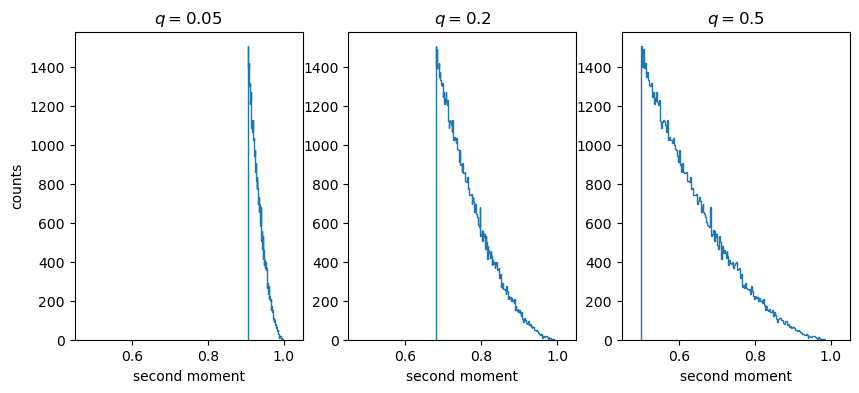

In [4]:
Histogram_data = np.load('Histogram_data.npz')
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))

counts_purity11a, bins_purity11a = np.histogram(Histogram_data['purities_21'][0], 200)
axes[0].stairs(counts_purity11a, bins_purity11a)
axes[0].set_xlim(0.45,1.05)
axes[0].set_ylabel('counts')
axes[0].set_xlabel('second moment')
axes[0].set_title('$q = 0.05$')

counts_purity11b, bins_purity11b = np.histogram(Histogram_data['purities_21'][1], 200)
axes[1].stairs(counts_purity11b, bins_purity11b)
axes[1].set_xlim(0.45,1.05)
axes[1].set_xlabel('second moment')
axes[1].set_title('$q = 0.2$')

counts_purity11c, bins_purity11c = np.histogram(Histogram_data['purities_21'][2], 200)
axes[2].stairs(counts_purity11c, bins_purity11c)
axes[2].set_xlim(0.45,1.05)
axes[2].set_xlabel('second moment')
axes[2].set_title('$q = 0.5$')

'''
counts_third11a, bins_third11a = np.histogram(Histogram_data['thirds_11'][0], 200)
axes[1,0].stairs(counts_third11a, bins_third11a)
axes[1,0].set_xlim(0.15,1.05)
axes[1,0].set_ylabel('counts')
axes[1,0].set_xlabel('third moment')

counts_third11b, bins_third11b = np.histogram(Histogram_data['thirds_11'][1], 200)
axes[1,1].stairs(counts_third11b, bins_third11b)
axes[1,1].set_xlim(0.15,1.05)
axes[1,1].set_xlabel('third moment')

counts_third11c, bins_third11c = np.histogram(Histogram_data['thirds_11'][2], 200)
axes[1,2].stairs(counts_third11c, bins_third11c)
axes[1,2].set_xlim(0.15,1.05)
axes[1,2].set_xlabel('third moment')
'''


## Experiment 2: empirical Haar moments as a function of $q$

Here I calculated the average first three scalar moments over Haar sampled states on $AB$, as a function of $q$. The result is not very interesting I would say. 

In [5]:
N_A = 1
N_B = 1
reps = 10000
qs = np.linspace(0,1,50)

traces_11 = np.zeros(50)
purities_11 = np.zeros(50)
thirds_11 = np.zeros(50)

for i, q in enumerate(qs):
    avg_trace = 0
    avg_purity = 0
    avg_third = 0
    for rep in range(reps):
        Psi = random_state(2**(N_A + N_B))
        Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        trace = 0
        purity = 0
        third = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
            third += p * np.trace(rho @ rho @ rho)
        
        avg_trace += np.real(trace) / reps
        avg_purity += np.real(purity) / reps
        avg_third += np.real(third) / reps
    
    traces_11[i] = avg_trace
    purities_11[i] = avg_purity
    thirds_11[i] = avg_third

    fig = plt.figure()



### Plots

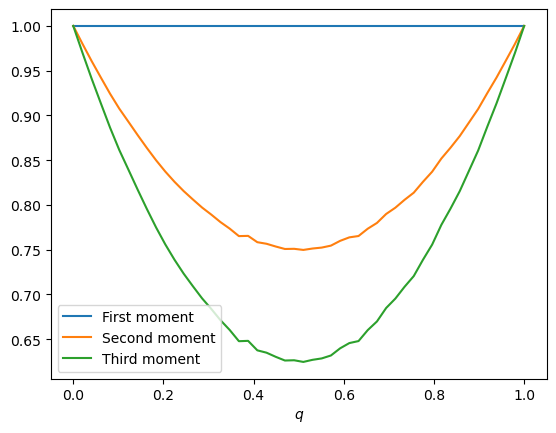

In [6]:
plt.plot(qs, traces_11, label='First moment')
plt.plot(qs, purities_11, label='Second moment')
plt.plot(qs, thirds_11, label='Third moment')
plt.xlabel('$q$')
plt.legend()
plt.show()

### Here the same, but for different system sizes. Again, ultimately not very interesting.

1000 reps for 12 and 21, 500 reps for 22, 100 reps for 51 and 15 (because it would take too long otherwise)

In [7]:
N_A = 2
N_B = 1
reps = 4000
qs = np.linspace(0,1,50)

purities_21 = np.zeros(50)


for i, q in enumerate(qs):
    avg_purity = 0
    for rep in range(reps):
        Psi = random_state(2**(N_A + N_B))
        Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        purity = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            purity += p * np.trace(rho @ rho)
        
        avg_purity += np.real(purity) / reps
    
    purities_21[i] = avg_purity


N_A = 1
N_B = 2
reps = 4000
qs = np.linspace(0,1,50)

purities_12 = np.zeros(50)


for i, q in enumerate(qs):
    avg_purity = 0
    for rep in range(reps):
        Psi = random_state(2**(N_A + N_B))
        Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        purity = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
        
        avg_purity += np.real(purity) / reps
    
    purities_12[i] = avg_purity

N_A = 2
N_B = 2
reps = 2000
qs = np.linspace(0,1,50)

purities_22 = np.zeros(50)


for i, q in enumerate(qs):
    avg_purity = 0
    for rep in range(reps):
        Psi = random_state(2**(N_A + N_B))
        Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        purity = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
        
        avg_purity += np.real(purity) / reps
    
    purities_22[i] = avg_purity

N_A = 1
N_B = 5
reps = 400
qs = np.linspace(0,1,50)

purities_15 = np.zeros(50)


for i, q in enumerate(qs):
    avg_purity = 0
    for rep in range(reps):
        Psi = random_state(2**(N_A + N_B))
        Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        purity = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
        
        avg_purity += np.real(purity) / reps
    
    purities_15[i] = avg_purity

N_A = 5
N_B = 1
reps = 400
qs = np.linspace(0,1,50)

purities_51 = np.zeros(50)


for i, q in enumerate(qs):
    avg_purity = 0
    for rep in range(reps):
        Psi = random_state(2**(N_A + N_B))
        Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
        Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

        purity = 0

        for j in range(len(Mixed_ensemble)):
            p = Mixed_ensemble[j][0]
            rho = Mixed_ensemble[j][1]
            trace += p * np.trace(rho)
            purity += p * np.trace(rho @ rho)
        
        avg_purity += np.real(purity) / reps
    
    purities_51[i] = avg_purity


### and some more plots

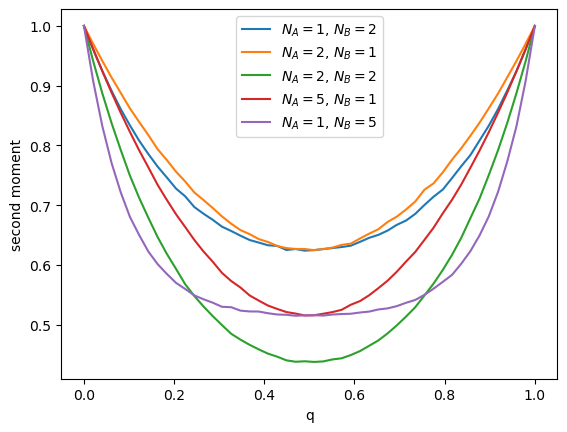

In [8]:
fig = plt.figure()
plt.plot(qs, purities_12, label='$N_A = 1$, $N_B = 2$')
plt.plot(qs, purities_21, label='$N_A = 2$, $N_B = 1$')
plt.plot(qs, purities_22, label='$N_A = 2$, $N_B = 2$')
plt.plot(qs, purities_51, label='$N_A = 5$, $N_B = 1$')
plt.plot(qs, purities_15, label='$N_A = 1$, $N_B = 5$')
plt.legend(loc='upper center')
plt.xlabel('q')
plt.ylabel('second moment')
plt.show()

## Experiment 3: higher moments

Following on specifically from experiment 1, I wanted to do something with the observation that the histograms of the second moment and the third moment can be said to have the 'same shape' (although between different values, shifted etc.). To quantify this observation just a little bit more, for a specific set of values $(N_A, N_B, q)$, I calculated histograms over Haar random states on $AB$ up to the seventh scalar moment $P^{(7)}$. The 'same shape' persisted. Data is gathered belowed and stored in file 'High_moments.npz'.

In [9]:
'''
N_A = 3
N_B = 7
q = 0.1
reps = 10000

traces = np.zeros(reps)
purities = np.zeros(reps)
thirds = np.zeros(reps)
fourths = np.zeros(reps)
fifths1 = np.zeros(reps)
sixths = np.zeros(reps)
sevenths = np.zeros(reps)

for rep in range(reps):
    Psi = random_state(2**(N_A + N_B))
    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
    Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

    trace = 0
    purity = 0
    third = 0
    fourth = 0
    fifth = 0
    sixth = 0
    seventh = 0

    for j in range(len(Mixed_ensemble)):
        p = Mixed_ensemble[j][0]
        rho = Mixed_ensemble[j][1]
        trace += p * np.trace(rho)
        purity += p * np.trace(rho @ rho)
        third += p * np.trace(rho @ rho @ rho)
        fourth += p * np.trace(rho @ rho @ rho @ rho)
        fifth += p * np.trace(rho @ rho @ rho @ rho @ rho)
        sixth += p * np.trace(rho @ rho @ rho @ rho @ rho @ rho)
        seventh += p * np.trace(rho @ rho @ rho @ rho @ rho @ rho @ rho)
            
    traces[rep] = np.real(trace)
    purities[rep] = np.real(purity)
    thirds[rep] = np.real(third)
    fourths[rep] = np.real(fourth)
    fifths[rep] = np.real(fifth)
    sixths[rep] = np.real(sixth)
    sevenths[rep] = np.real(seventh)

np.savez('High_moments',
         traces=traces,
         purities=purities,
         thirds=thirds,
         fourths=fourths,
         fifths=fifths,
         sixths=sixths,
         sevenths=sevenths)
'''

"\nN_A = 3\nN_B = 7\nq = 0.1\nreps = 10000\n\ntraces = np.zeros(reps)\npurities = np.zeros(reps)\nthirds = np.zeros(reps)\nfourths = np.zeros(reps)\nfifths1 = np.zeros(reps)\nsixths = np.zeros(reps)\nsevenths = np.zeros(reps)\n\nfor rep in range(reps):\n    Psi = random_state(2**(N_A + N_B))\n    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)\n    Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)\n\n    trace = 0\n    purity = 0\n    third = 0\n    fourth = 0\n    fifth = 0\n    sixth = 0\n    seventh = 0\n\n    for j in range(len(Mixed_ensemble)):\n        p = Mixed_ensemble[j][0]\n        rho = Mixed_ensemble[j][1]\n        trace += p * np.trace(rho)\n        purity += p * np.trace(rho @ rho)\n        third += p * np.trace(rho @ rho @ rho)\n        fourth += p * np.trace(rho @ rho @ rho @ rho)\n        fifth += p * np.trace(rho @ rho @ rho @ rho @ rho)\n        sixth += p * np.trace(rho @ rho @ rho @ rho @ rho @ rho)\n        seventh += p * np.trace(rho @ rho @ rho @ rho @ 

### and the plots

10000


Text(0.5, 0, 'seventh moment')

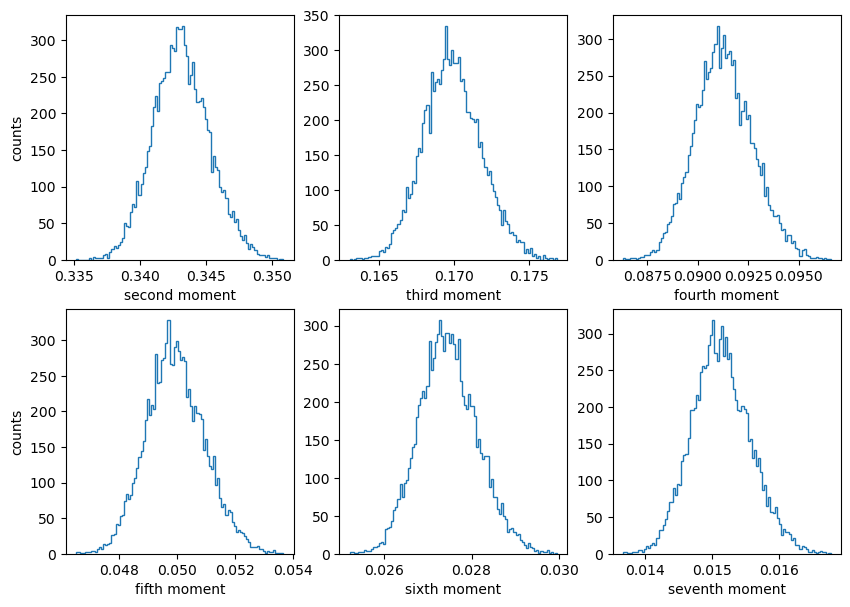

In [10]:
data = np.load('High_moments.npz')
print(np.count_nonzero(data['traces']))
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,7))

counts_purity, bins_purity = np.histogram(data['purities'], 100)
axes[0,0].stairs(counts_purity, bins_purity)
axes[0,0].set_ylabel('counts')
axes[0,0].set_xlabel('second moment')

counts_third, bins_third = np.histogram(data['thirds'], 100)
axes[0,1].stairs(counts_third, bins_third)
axes[0,1].set_xlabel('third moment')

counts_fourth, bins_fourth = np.histogram(data['fourths'], 100)
axes[0,2].stairs(counts_fourth, bins_fourth)
axes[0,2].set_xlabel('fourth moment')


counts_fifth, bins_fifth = np.histogram(data['fifths'], 100)
axes[1,0].stairs(counts_fifth, bins_fifth)
axes[1,0].set_ylabel('counts')
axes[1,0].set_xlabel('fifth moment')

counts_sixth, bins_sixth = np.histogram(data['sixths'], 100)
axes[1,1].stairs(counts_sixth, bins_sixth)
axes[1,1].set_xlabel('sixth moment')

counts_seventh, bins_seventh = np.histogram(data['sevenths'], 100)
axes[1,2].stairs(counts_seventh, bins_seventh)
axes[1,2].set_xlabel('seventh moment')

## Now it gets just a little bit silly

## Experiment 4: uniform rotations in Hilbert space

PURELY FOR ILLUSTRATION, THIS CODE IS PRETTY USELESS

Here I basically took a list of unitaries, and looked at what happened when I rotated the ensemble moments (the operator moments that is) under these unitaries, i.e. what the maximum and average deviation were in terms of some traces, relative to the trace square or something like that of the ensemble itself, for several repetitions and comparing the error free pure ensemble and the mixed ensemble with error. This is basically useless I think. I did this both for random states and lowly entangled early time quenched states (but that code is deleted). 

In [9]:
# Let's make a list of random unitaries of some given size, let's say 8 by 8 (N_A = 3)
unitaries = []

for i in range(10):
    unitaries.append(unitary_group.rvs(2))

# Lists of data: for 100 random states from which we obtain projected ensembles, the frame potential and the maximum
# deviation of between the true and the rotated frame potential, for the first three moments.
reps = 10
pure_data_1 = np.zeros((reps,3))
pure_data_2 = np.zeros((reps,3))
pure_data_3 = np.zeros((reps,3))
mixed_data_1 = np.zeros((reps,3))
mixed_data_2 = np.zeros((reps,3))
mixed_data_3 = np.zeros((reps,3))

# Parameters
N_A = 1
N_B = 7
q = 0.1

In [10]:
for i in range(reps):
    # Generate mixed ensemble
    Psi = random_state(2**(N_A + N_B))
    Projected_ensemble = Get_PrEns(Psi, N_A, N_B)
    Mixed_ensemble = Get_MixEns(Projected_ensemble, N_A, N_B, q)

    pure_potential_1 = 0
    pure_rotated_potentials_1 = np.zeros(len(unitaries))
    pure_potential_2 = 0
    pure_rotated_potentials_2 = np.zeros(len(unitaries))
    pure_potential_3 = 0
    pure_rotated_potentials_3 = np.zeros(len(unitaries))
    mixed_potential_1 = 0
    mixed_rotated_potentials_1 = np.zeros(len(unitaries))
    mixed_potential_2 = 0
    mixed_rotated_potentials_2 = np.zeros(len(unitaries))
    mixed_potential_3 = 0
    mixed_rotated_potentials_3 = np.zeros(len(unitaries))
    

    for m in range(len(Mixed_ensemble)):
        p_m_mix = Mixed_ensemble[m][0]
        p_m_pure = Projected_ensemble[m][0]
        rho_m = Mixed_ensemble[m][1]
        psi_m = Projected_ensemble[m][1]
        for n in range(len(Mixed_ensemble)):
            p_n_mix = Mixed_ensemble[n][0]
            p_n_pure = Projected_ensemble[n][0]
            rho_n = Mixed_ensemble[n][1]
            psi_n = Projected_ensemble[n][1]

            pure_potential_1 += p_m_pure * p_n_pure * np.absolute(np.vdot(psi_m, psi_n)) ** 2
            pure_potential_2 += p_m_pure * p_n_pure * np.absolute(np.vdot(psi_m, psi_n)) ** 4
            pure_potential_3 += p_m_pure * p_n_pure * np.absolute(np.vdot(psi_m, psi_n)) ** 6
            mixed_potential_1 += p_m_mix * p_n_mix * np.real(np.trace(rho_m @ rho_n))
            mixed_potential_2 += p_m_mix * p_n_mix * np.real(np.trace(rho_m @ rho_n)) ** 2
            mixed_potential_3 += p_m_mix * p_n_mix * np.real(np.trace(rho_m @ rho_n)) ** 3

            for j, U in enumerate(unitaries):
                pure_rotated_potentials_1[j] += p_m_mix * p_n_mix * np.absolute(np.vdot(psi_m, U @ psi_n)) ** 2
                pure_rotated_potentials_2[j] += p_m_mix * p_n_mix * np.absolute(np.vdot(psi_m, U @ psi_n)) ** 4
                pure_rotated_potentials_3[j] += p_m_mix * p_n_mix * np.absolute(np.vdot(psi_m, U @ psi_n)) ** 6
                mixed_rotated_potentials_1[j] += p_m_mix * p_n_mix * np.real(np.trace(rho_m @ U @ rho_n @ np.conjugate(np.transpose(U))))
                mixed_rotated_potentials_2[j] += p_m_mix * p_n_mix * np.real(np.trace(rho_m @ U @ rho_n @ np.conjugate(np.transpose(U)))) ** 2
                mixed_rotated_potentials_3[j] += p_m_mix * p_n_mix * np.real(np.trace(rho_m @ U @ rho_n @ np.conjugate(np.transpose(U)))) ** 3

    pure_data_1[i][0] = pure_potential_1
    pure_data_2[i][0] = pure_potential_2
    pure_data_3[i][0] = pure_potential_3
    pure_data_1[i][1] = np.max(pure_potential_1 - pure_rotated_potentials_1) / pure_potential_1
    pure_data_2[i][1] = np.max(pure_potential_2 - pure_rotated_potentials_2) / pure_potential_2
    pure_data_3[i][1] = np.max(pure_potential_3 - pure_rotated_potentials_3) / pure_potential_3
    pure_data_1[i][2] = np.average(pure_potential_1 - pure_rotated_potentials_1) / pure_potential_1
    pure_data_2[i][2] = np.average(pure_potential_2 - pure_rotated_potentials_2) / pure_potential_2
    pure_data_3[i][2] = np.average(pure_potential_3 - pure_rotated_potentials_3) / pure_potential_3
    mixed_data_1[i][0] = mixed_potential_1
    mixed_data_2[i][0] = mixed_potential_2
    mixed_data_3[i][0] = mixed_potential_3
    mixed_data_1[i][1] = np.max(mixed_potential_1 - mixed_rotated_potentials_1) / mixed_potential_1
    mixed_data_2[i][1] = np.max(mixed_potential_2 - mixed_rotated_potentials_2) / mixed_potential_2
    mixed_data_3[i][1] = np.max(mixed_potential_3 - mixed_rotated_potentials_3) / mixed_potential_3
    mixed_data_1[i][2] = np.average(mixed_potential_1 - mixed_rotated_potentials_1) / mixed_potential_1
    mixed_data_2[i][2] = np.average(mixed_potential_2 - mixed_rotated_potentials_2) / mixed_potential_2
    mixed_data_3[i][2] = np.average(mixed_potential_3 - mixed_rotated_potentials_3) / mixed_potential_3


In [11]:
print(pure_data_3)
print(mixed_data_3)

[[0.25863801 0.04251298 0.03175242]
 [0.26710682 0.08157978 0.05972602]
 [0.25649966 0.03125656 0.02525798]
 [0.25777321 0.04234995 0.02755983]
 [0.25181667 0.00984048 0.00676843]
 [0.25835075 0.03861526 0.03078409]
 [0.26575971 0.07738742 0.05793003]
 [0.25433725 0.02182724 0.01640572]
 [0.25277378 0.01487048 0.00986979]
 [0.25835073 0.03845506 0.03036079]]
[[0.13703788 0.05357618 0.03029157]
 [0.13863611 0.07183354 0.03785484]
 [0.13391485 0.01756949 0.00955739]
 [0.13947811 0.08020945 0.03869449]
 [0.13332713 0.01790921 0.01043554]
 [0.13599674 0.03307337 0.01642104]
 [0.13851076 0.05368579 0.03115286]
 [0.1332325  0.01617762 0.00994833]
 [0.13586262 0.02985214 0.01494418]
 [0.13589409 0.03921134 0.02068048]]


## Experiment 5: compare $N_A=1$ mixed ensembles to Bloch ball

Here I was ultimately not that far off but still being a bit useless. I was trying to find some idealised ensemble for $N_A = 1$ on the Bloch ball (like how the Haar ensemble corresponds to taking the uniform average over the Bloch sphere). I now realise that my 'new ensemble' for $N_A = 1$ is actually the sphere inside the Bloch ball with radius $1-r$. But what I did here was just compare moments to those over the entire Bloch ball, or to look at shells in between specific radii. It didn't yield anything sensible.

I constructed an 'empirical bloch ensemble' by sampling points inside the sphere and using the Pauli basis for density matrices. Then for different $N_B$ I picked a couple Haar random states on $AB$, calculated the moments of the mixed ensemble and compared to the Bloch shells.

In [12]:
N_A = 1
N_Bs = [4, 5, 6, 7, 8, 9]
p = 0.1
dist = np.zeros((3,6))
reps = 10

I = np.array([[1,0], [0,1]], dtype='complex128')
sx = np.array([[0,1], [1,0]], dtype='complex128')
sy = np.array([[0,-1j], [1j,0]], dtype='complex128')
sz = np.array([[1,0], [0,-1]], dtype='complex128')

# 'Empirical Bloch'
Emp_Bloch = np.empty((1000,2)).tolist()
count = 0
while count < 1000:
    Px = np.random.rand()
    Py = np.random.rand()
    Pz = np.random.rand()
    if Px ** 2 + Py ** 2 + Pz ** 2 <= 1:
        Emp_Bloch[count][0] = 0.001
        Emp_Bloch[count][1] = 0.5 * I + 0.5 * ( Px * sx + Py * sy + Pz * sz )
        count += 1


for i, N_B in enumerate(N_Bs):
    for j in range(reps):
        Psi = random_state(2 ** (N_A + N_B))
        PrEns = Get_PrEns(Psi, N_A, N_B)
        MixEns = Get_MixEns(PrEns, N_A, N_B ,p)

        dist[0][i] += np.linalg.norm(rho_MixEns(MixEns, 1) - rho_MixEns(Emp_Bloch, 1), 'nuc') / (2 * reps)
        dist[1][i] += np.linalg.norm(rho_MixEns(MixEns, 2) - rho_MixEns(Emp_Bloch, 2), 'nuc') / (2 * reps)
        dist[2][i] += np.linalg.norm(rho_MixEns(MixEns, 3) - rho_MixEns(Emp_Bloch, 3), 'nuc') / (2 * reps)

### and the plots, not very nice...

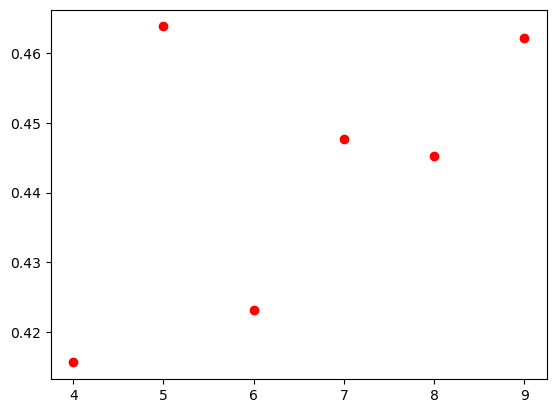

In [13]:
fig = plt.figure()
plt.plot(N_Bs, dist[2], 'ro')
plt.show()

# Round 2: correlations

I hit on something a bit more fruitful when I started considering how the 'mixing' up of pure states into mixed states weighted by conditional probabilities p(m'|m) would make the ensemble either more or less 'uniformly random'. I realised that this depended on how different states in the pure ensemble correlate to conditional probabilities associated with their readout strings. So a natural thing to consider became the extent to which there is a correlation between Hamming distance between two readout strings, and the overlap between their associated states on $A$.

## Experiment 6: first exploration, scatter plots
Here I just started exploring by going over all pairs of states in the projected ensemble of pure states, finding the Hamming distance between their measurement readout and their squred overlaps, and plotting a scatterplot. I did that for a random state, and then for an early-time quenched state. The results suggest limited or no correlation, beyond the trivial correlation that distinguishes zero Hamming distance (with guarenteed maximum overlap) from nonzero Hamming distance.

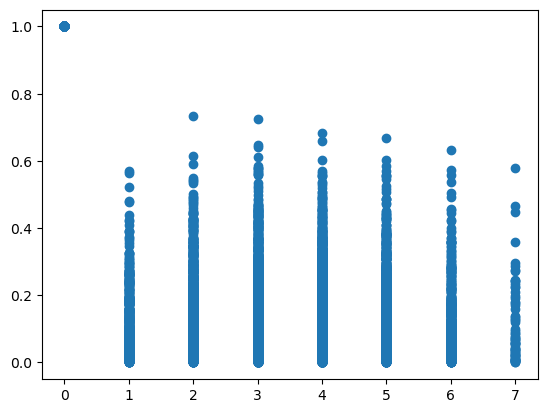

In [16]:
# Random stat

N_A = 3
N_B = 7
Psi = random_state(1024)
PrEns = Get_PrEns(Psi, N_A, N_B)
distances = []
overlaps = []
for i in range(2**N_B):
    for j in range(i, 2**N_B):
        str_i = format(i, f'0{N_B}b')
        str_j = format(j, f'0{N_B}b')
        dist = Hamming(str_i, str_j)
        distances.append(dist)

        psi_i = PrEns[i][1]
        psi_j = PrEns[j][1]
        overlap = np.absolute(np.vdot(psi_i, psi_j)) ** 2
        overlaps.append(overlap)

fig = plt.figure()
plt.scatter(distances, overlaps)
plt.show()

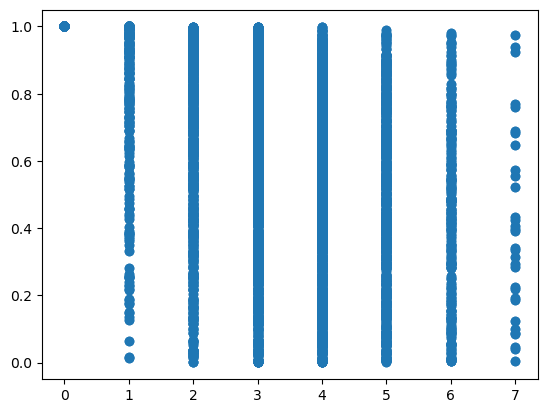

In [17]:
# Early time quenched state

N_A = 3
N_B = 7
N = N_A + N_B
h_x = 0.8090
h_y = 0.9045
J = 1

Psi0 = np.zeros(2**N)
Psi0[0] = 1
Hamiltonian = QIMF(N, h_x, h_y, J)
U = expm(-1j * Hamiltonian)
Psi = U @ Psi0

PrEns = Get_PrEns(Psi, N_A, N_B)
distances = []
overlaps = []
for i in range(2**N_B):
    for j in range(i, 2**N_B):
        str_i = format(i, f'0{N_B}b')
        str_j = format(j, f'0{N_B}b')
        dist = Hamming(str_i, str_j)
        distances.append(dist)

        psi_i = PrEns[i][1]
        psi_j = PrEns[j][1]
        overlap = np.absolute(np.vdot(psi_i, psi_j)) ** 2
        overlaps.append(overlap)

fig = plt.figure()
plt.scatter(distances, overlaps)
plt.show()

## Experiment 7: Histograms and correlation coefficients


Here I tried to make the above finding a bit more precise. I took 100 Haar random states on $AB$. For each state, I considered every pair of states in the projected ensemble, and got an ordered list of Hamming distances and associated squared overlaps, and I calculated the Pearson correlation coefficient between Hamming distance and overlap. I ignored pairs of identical states (Hamming distance zero), so that the expected correlation coefficient would always be zero. I then combined all the data and plotted a histogram of the distribution of squared overlaps per Hamming distance, I plotted the average overlap with stdev for each Hamming distance, and I computed the average correlation coefficient over the 100 states. As expected I found a correlation statistically indistinguishable from zero.

In [8]:
# Random states
N_A = 3
N_B = 7

distances = []
overlaps = []
correlations = []

for rep in range(100):
    Psi = random_state(2 ** (N_A + N_B))
    PrEns = Get_PrEns(Psi, N_A, N_B)
    dists = []
    olaps = []
    for i in range(2**N_B):
        for j in range(i, 2**N_B):
            str_i = format(i, f'0{N_B}b')
            str_j = format(j, f'0{N_B}b')
            dist = Hamming(str_i, str_j)
            if dist > 0:
                dists.append(dist)

                psi_i = PrEns[i][1]
                psi_j = PrEns[j][1]
                overlap = np.absolute(np.vdot(psi_i, psi_j)) ** 2
                olaps.append(overlap)

    r = np.corrcoef(dists, olaps)[0,1]
    distances += dists
    overlaps += olaps
    correlations.append(r)

sorted_data = []
for dist in range(1, max(distances) + 1):
    data = []
    for i in range(len(distances)):
        if distances[i] == dist:
            data.append(overlaps[i])
    sorted_data.append([str(dist), np.array(data)])

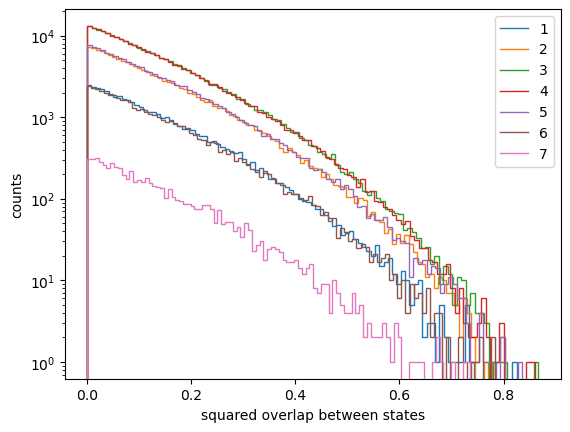

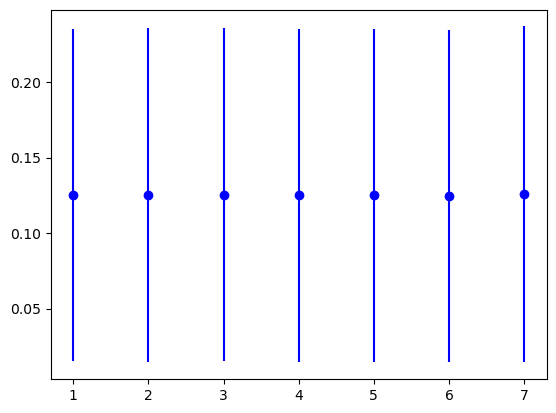

Average correlation is -0.0013
Standard deviation of correlations is  0.010
Maximum correlation is  0.031
Minimum correlation is -0.027
-0.0012792813639262127


In [12]:
fig = plt.figure()
for dist in range(len(sorted_data)):
    counts, bins = np.histogram(sorted_data[dist][1], bins=100)
    plt.stairs(counts, bins, label=sorted_data[dist][0])
plt.yscale('log')
plt.xlabel('squared overlap between states')
plt.ylabel('counts')
plt.legend()
plt.show()

averages = [np.average(sorted_data[i][1]) for i in range(len(sorted_data))]
stdevs = [np.std(sorted_data[i][1]) for i in range(len(sorted_data))]
fig = plt.figure()
plt.errorbar([i + 1 for i in range(len(sorted_data))], averages,stdevs, fmt='bo')
plt.show()

print(f'Average correlation is {np.average(correlations): .4f}')
print(f'Standard deviation of correlations is {np.std(correlations): .3f}')
print(f'Maximum correlation is {np.max(correlations): .3f}')
print(f'Minimum correlation is {np.min(correlations): .3f}')


I then repeated the same thing but for a single early-time quenched state (which can't be considered yet to be randomly sampled from Hilbert space). Again I got a histogram, average overlap with each Hamming distance, and a correlation coefficient. As it is only one state instead of 100 the histogram is not very informative, except the high overlap peak for Hamming distance 1. Now I found that there still was a negative correlation between Hamming distance and overlap: low Hamming distance was more likely to give a large overlap.

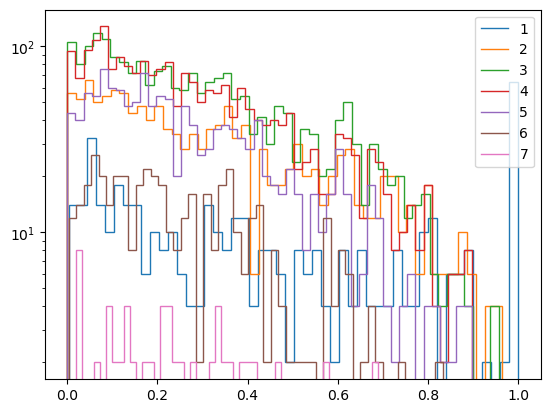

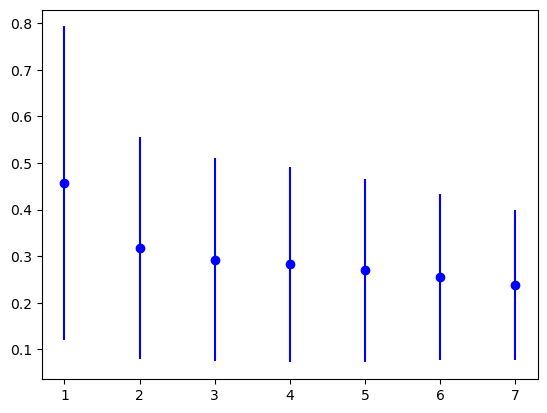

-0.24641679078975604


In [16]:
# Early quenched states
N_A = 3
N_B = 7
N = N_A + N_B
h_x = 0.8090
h_y = 0.9045
J = 1

Psi0 = np.zeros(2**N)
Psi0[0] = 1
Hamiltonian = QIMF(N, h_x, h_y, J)
U = expm(-2j * Hamiltonian)
Psi = U @ Psi0
PrEns = Get_PrEns(Psi, N_A, N_B)
distances = []
overlaps = []
for i in range(2**N_B):
    for j in range(i, 2**N_B):
        str_i = format(i, f'0{N_B}b')
        str_j = format(j, f'0{N_B}b')
        dist = Hamming(str_i, str_j)
        distances.append(dist)

        psi_i = PrEns[i][1]
        psi_j = PrEns[j][1]
        overlap = np.absolute(np.vdot(psi_i, psi_j)) ** 2
        overlaps.append(overlap)


sorted_data = []
for dist in range(1, max(distances) + 1):
    data = []
    for i in range(len(distances)):
        if distances[i] == dist:
            data.append(overlaps[i])
    sorted_data.append([str(dist), np.array(data)])

fig = plt.figure()
for dist in range(len(sorted_data)):
    counts, bins = np.histogram(sorted_data[dist][1], bins=50)
    plt.stairs(counts, bins, label=sorted_data[dist][0])
plt.yscale('log')
plt.legend()
plt.show()

averages = [np.average(sorted_data[i][1]) for i in range(len(sorted_data))]
stdevs = [np.std(sorted_data[i][1]) for i in range(len(sorted_data))]
fig = plt.figure()
plt.errorbar([i + 1 for i in range(len(sorted_data))], averages,stdevs, fmt='bo')
plt.show()

r = np.corrcoef(distances, overlaps)
print(r[0,1])

## Experiment 8: correlation coefficient with time for quenched state

Building on from the above I wanted to investigate the correlation for quenched state further. I didn't bother with histograms anymore and just calculated the Pearson correlation coefficient for each time with a chaotic quenched state, once again under the QIMF Hamiltonian following Cotler et al. Note that this was once considering only pairs of different states (i.e. removing zero Hamming distance pairs). I did this for early times, intermediate times and late times.

I also calculated the average correlation for very late times, which was different from zero, so a kind of correlation persists.

In [20]:
# Correlations with time
N_A = 2
N_B = 6
N = N_A + N_B
h_x = 0.8090
h_y = 0.9045
J = 1
Hamiltonian = QIMF(N, h_x, h_y, J)

## Early times
times_1 = np.linspace(0.01,3,1000)
correlations_1 = np.zeros(1000)

for i, t in enumerate(times_1):

    Psi0 = np.zeros(2 ** N)
    Psi0[0] = 1
    U = expm(-1j * t * Hamiltonian)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    distances = []
    overlaps = []
    for j in range(2 ** N_B):
        for k in range(j, 2**N_B):
            str_j = format(j, f'0{N_B}b')
            str_k = format(k, f'0{N_B}b')
            dist = Hamming(str_j, str_k)
            
            if dist > 0:
                distances.append(dist)

                psi_j = PrEns[j][1]
                psi_k = PrEns[k][1]
                overlap = np.absolute(np.vdot(psi_j, psi_k)) ** 2
                overlaps.append(overlap)

    r = np.corrcoef(distances, overlaps)
    correlations_1[i] = r[0,1]

## Intermediate times
times_2 = np.linspace(0.1,20,1000)
correlations_2 = np.zeros(1000)

for i, t in enumerate(times_2):

    Psi0 = np.zeros(2 ** N)
    Psi0[0] = 1
    U = expm(-1j * t * Hamiltonian)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    distances = []
    overlaps = []
    for j in range(2 ** N_B):
        for k in range(j, 2**N_B):
            str_j = format(j, f'0{N_B}b')
            str_k = format(k, f'0{N_B}b')
            dist = Hamming(str_j, str_k)
            
            if dist > 0:
                distances.append(dist)

                psi_j = PrEns[j][1]
                psi_k = PrEns[k][1]
                overlap = np.absolute(np.vdot(psi_j, psi_k)) ** 2
                overlaps.append(overlap)

    r = np.corrcoef(distances, overlaps)
    correlations_2[i] = r[0,1]

## Late times
times_3 = np.linspace(0.1,1000,1000)
correlations_3 = np.zeros(1000)

for i, t in enumerate(times_3):

    Psi0 = np.zeros(2 ** N)
    Psi0[0] = 1
    U = expm(-1j * t * Hamiltonian)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    distances = []
    overlaps = []
    for j in range(2 ** N_B):
        for k in range(j, 2**N_B):
            str_j = format(j, f'0{N_B}b')
            str_k = format(k, f'0{N_B}b')
            dist = Hamming(str_j, str_k)
            
            if dist > 0:
                distances.append(dist)

                psi_j = PrEns[j][1]
                psi_k = PrEns[k][1]
                overlap = np.absolute(np.vdot(psi_j, psi_k)) ** 2
                overlaps.append(overlap)

    r = np.corrcoef(distances, overlaps)
    correlations_3[i] = r[0,1]

Text(0.5, 1.0, 'intermediate times')

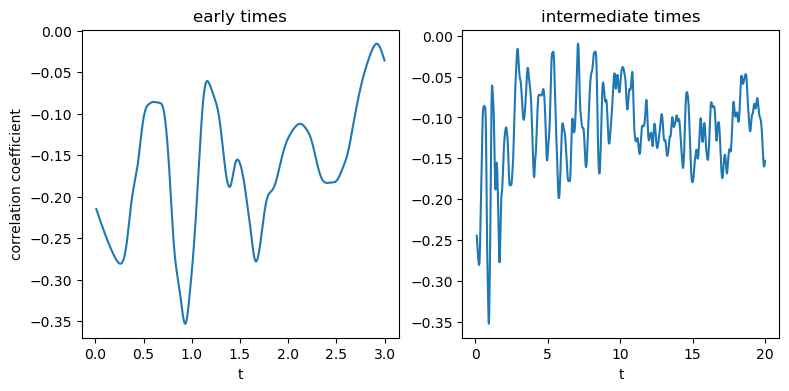

In [40]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(9,4))

axes[0].plot(times_1, correlations_1)
axes[0].set_ylabel('correlation coefficient')
axes[0].set_xlabel('t')
axes[0].set_title('early times')

axes[1].plot(times_2, correlations_2)
axes[1].set_xlabel('t')
axes[1].set_title('intermediate times')

In [35]:
# late time average correlation
N_A = 2
N_B = 6
N = N_A + N_B
h_x = 0.8090
h_y = 0.9045
J = 1
Hamiltonian = QIMF(N, h_x, h_y, J)

## Early times
times = np.linspace(10000000,15000000,100)
correlations = np.zeros(100)

for i, t in enumerate(times):

    Psi0 = np.zeros(2 ** N)
    Psi0[0] = 1
    U = expm(-1j * t * Hamiltonian)
    Psi = U @ Psi0
    PrEns = Get_PrEns(Psi, N_A, N_B)
    distances = []
    overlaps = []
    for j in range(2 ** N_B):
        for k in range(j, 2**N_B):
            str_j = format(j, f'0{N_B}b')
            str_k = format(k, f'0{N_B}b')
            dist = Hamming(str_j, str_k)
            
            if dist > 0:
                distances.append(dist)

                psi_j = PrEns[j][1]
                psi_k = PrEns[k][1]
                overlap = np.absolute(np.vdot(psi_j, psi_k)) ** 2
                overlaps.append(overlap)

    r = np.corrcoef(distances, overlaps)
    correlations[i] = r[0,1]

### Late time average and stdev

In [36]:
print(np.average(correlations))
print(np.std(correlations))

-0.10236910330098625
0.04117800282265641


## Experiment 9: does correlation really persist? Changing fields
Generally we expect correlation to vanish at large times for an ergodic Hamiltonian as for large times the system can be thought of as exploring all of Hilbert space. So the finding above was somewhat surprising. The suggestion was that it might be a finite size effect.

I initially tried to enforce chaos more quickly and more drastically by switching between different fields. This makes the Hamiltonian time-dependent and breaks energy conservation. It is possible I made some mistakes here, but the outcome was that late time negative correlation still persisted.

In [183]:
# Correlations with time
N_A = 2
N_B = 6
N = N_A + N_B
h_x = 0.8090
h_y = 0.9045
J = 1

H_1 = QIMF(N, 0.5 * h_x, 1.5 * h_y, J)
H_2 = QIMF(N, 1.5 * h_x, 0.5 * h_y, J)

## Early times
step = 0.01
early_times = np.arange(step, 3, step)
early_correlations = np.zeros(len(early_times))

U_1 = expm(-step * 1j * H_1)
U_2 = expm(-step * 1j * H_2)
Psi = np.zeros(2 ** N)
Psi[0] = 1
for i in range(len(early_times)):
    if i % 2 == 0:
        U = U_1
    if i % 2 == 1:
        U = U_2
    Psi = U @ Psi
    PrEns = Get_PrEns(Psi, N_A, N_B)
    distances = []
    overlaps = []
    for j in range(2 ** N_B):
        for k in range(j, 2**N_B):
            str_j = format(j, f'0{N_B}b')
            str_k = format(k, f'0{N_B}b')
            dist = Hamming(str_j, str_k)
            
            if dist > 0:
                distances.append(dist)

                psi_j = PrEns[j][1]
                psi_k = PrEns[k][1]
                overlap = np.absolute(np.vdot(psi_j, psi_k)) ** 2
                overlaps.append(overlap)

    r = np.corrcoef(distances, overlaps)
    early_correlations[i] = r[0,1]

## Intermediate times
step = 0.1
inter_times = np.arange(step, 20, step)
inter_correlations = np.zeros(len(inter_times))

U_1 = expm(-step * 1j * H_1)
U_2 = expm(-step * 1j * H_2)
Psi = np.zeros(2 ** N)
Psi[0] = 1
for i in range(len(inter_times)):
    if i % 2 == 0:
        U = U_1
    if i % 2 == 1:
        U = U_2
    Psi = U @ Psi
    PrEns = Get_PrEns(Psi, N_A, N_B)
    distances = []
    overlaps = []
    for j in range(2 ** N_B):
        for k in range(j, 2**N_B):
            str_j = format(j, f'0{N_B}b')
            str_k = format(k, f'0{N_B}b')
            dist = Hamming(str_j, str_k)
            
            if dist > 0:
                distances.append(dist)

                psi_j = PrEns[j][1]
                psi_k = PrEns[k][1]
                overlap = np.absolute(np.vdot(psi_j, psi_k)) ** 2
                overlaps.append(overlap)

    r = np.corrcoef(distances, overlaps)
    inter_correlations[i] = r[0,1]


## Late times
step = 1
late_times = np.arange(step, 1000, step)
late_correlations = np.zeros(len(late_times))

U_1 = expm(-step * 1j * H_1)
U_2 = expm(-step * 1j * H_2)
Psi = np.zeros(2 ** N)
Psi[0] = 1
for i in range(len(late_times)):
    if i % 2 == 0:
        U = U_1
    if i % 2 == 1:
        U = U_2
    Psi = U @ Psi
    PrEns = Get_PrEns(Psi, N_A, N_B)
    distances = []
    overlaps = []
    for j in range(2 ** N_B):
        for k in range(j, 2**N_B):
            str_j = format(j, f'0{N_B}b')
            str_k = format(k, f'0{N_B}b')
            dist = Hamming(str_j, str_k)
            
            if dist > 0:
                distances.append(dist)

                psi_j = PrEns[j][1]
                psi_k = PrEns[k][1]
                overlap = np.absolute(np.vdot(psi_j, psi_k)) ** 2
                overlaps.append(overlap)

    r = np.corrcoef(distances, overlaps)
    late_correlations[i] = r[0,1]


Text(0.5, 1.0, 'late times')

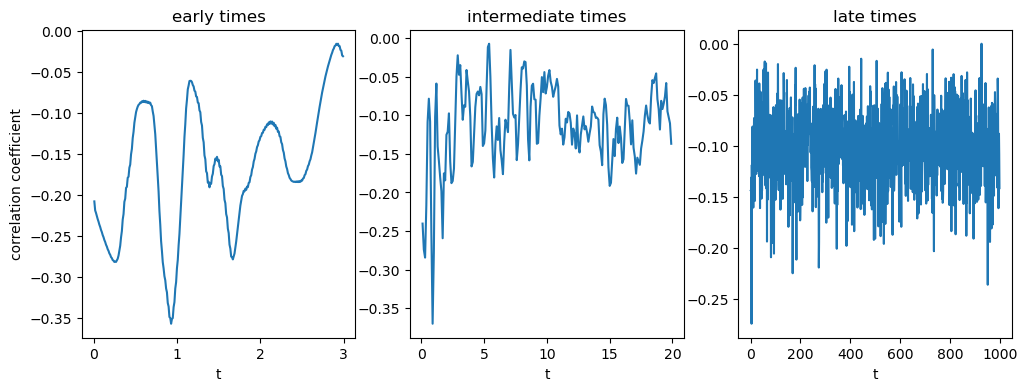

In [184]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))

axes[0].plot(early_times, early_correlations)
axes[0].set_ylabel('correlation coefficient')
axes[0].set_xlabel('t')
axes[0].set_title('early times')

axes[1].plot(inter_times, inter_correlations)
axes[1].set_xlabel('t')
axes[1].set_title('intermediate times')

axes[2].plot(late_times, late_correlations)
axes[2].set_xlabel('t')
axes[2].set_title('late times')

## Experiment 10: does correlation really persist? Scaling with $N_B$

I ultimately realised that, although I had no access to significantly larger system sizes, I could look at the scaling of the late time average with $N_B$, and extrapolate from there. The result was that for increasing $N_B$ the late time correlation tended more and more to zero and with smaller standard deviation, leading me to believe that this is indeed a finite size effect.

In [18]:
# late time average correlation
N_A = 2
h_x = 0.8090
h_y = 0.9045
J = 1

N_Bs = [4,5,6,7,8]
reps = 50
times = np.linspace(10000000,15000000,reps)
correlations = np.zeros((2,5))

for m, N_B in enumerate(N_Bs):
    
    corrs = np.zeros(reps)
    N = N_A + N_B
    Hamiltonian = QIMF(N, h_x, h_y, J)

    for i, t in enumerate(times):

        Psi0 = np.zeros(2 ** N)
        Psi0[0] = 1
        U = expm(-1j * t * Hamiltonian)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        distances = []
        overlaps = []
        for j in range(2 ** N_B):
            for k in range(j, 2**N_B):
                str_j = format(j, f'0{N_B}b')
                str_k = format(k, f'0{N_B}b')
                dist = Hamming(str_j, str_k)
                
                if dist > 0:
                    distances.append(dist)

                    psi_j = PrEns[j][1]
                    psi_k = PrEns[k][1]
                    overlap = np.absolute(np.vdot(psi_j, psi_k)) ** 2
                    overlaps.append(overlap)

        r = np.corrcoef(distances, overlaps)
        corrs[i] = r[0,1]
    correlations[0,m] = np.average(corrs)
    correlations[1,m] = np.std(corrs)

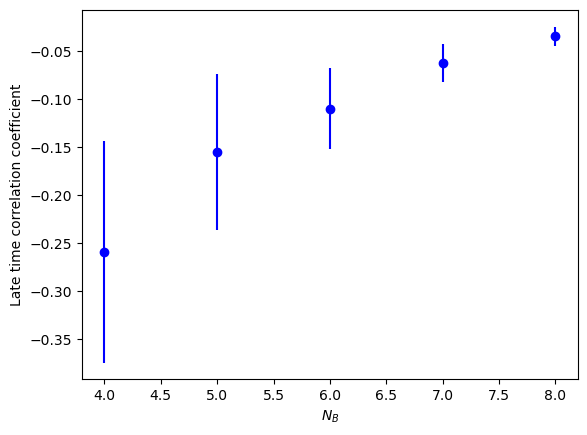

In [19]:
fig = plt.figure()
plt.errorbar(N_Bs, correlations[0], correlations[1], fmt='bo')
plt.xlabel('$N_B$')
plt.ylabel('Late time correlation coefficient')
plt.show()
